In [105]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
from scipy.io import loadmat
import loaders
from preprocessing.vsdi_preprocessing import clean_outliers,pca_ica,glm
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

# Component matching across animals

In [8]:
datapath = Path('/ceph/imaging1/davide/ATC_Data_preprocessed')

animals = ['A04','A06','A07','A08']
days = ['Day1','Day3','Day5','Day7']



In [97]:
def find_bounding_rectangle(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        return (x, y), (x + w, y + h)
    else:
        return None
    
def crop_to_bounds(image,bounds):
    return image[bounds[0][1]:bounds[1][1],bounds[0][0]:bounds[1][0]] 

def resize(mask_list):
    max_h = np.max([x.shape[0] for x in mask_list])
    max_w = np.max([x.shape[1] for x in mask_list])
    
    resized = []
    for m in mask_list:
        resized_mask = cv2.resize(m, (max_w, max_h), interpolation=cv2.INTER_CUBIC)
        resized.append(resized_mask)
    
    return resized

In [92]:
processed_datapath = Path('/scratch/dspalla/ATC_analysis')
components_list =[]
mask_list = []
labels = []
for i,animal in enumerate(animals):
    footprints = np.load(processed_datapath.joinpath(f'footprints_{animal}.npy'))
    components_list += list(np.load(processed_datapath.joinpath(f'footprints_{animal}.npy')))
    mask_list.append(np.load(processed_datapath.joinpath(f'mask_total_{animal}.npy')).astype('uint8'))
    labels += list(np.full(len(footprints),i)) 

In [106]:
mask_bboxes = [find_bounding_rectangle(m) for m in mask_list]


cropped_components = []
for c,l in zip(components_list,labels):
    cropped_components.append(crop_to_bounds(c,mask_bboxes[l]))
    

cropped_masks = [crop_to_bounds(m,bb) for m,bb in zip(mask_list,mask_bboxes)]

resized_components = resize(cropped_components)
resized_masks = resize(cropped_masks)

total_mask = reduce(lambda x, y: np.logical_and(x, y), resized_masks)



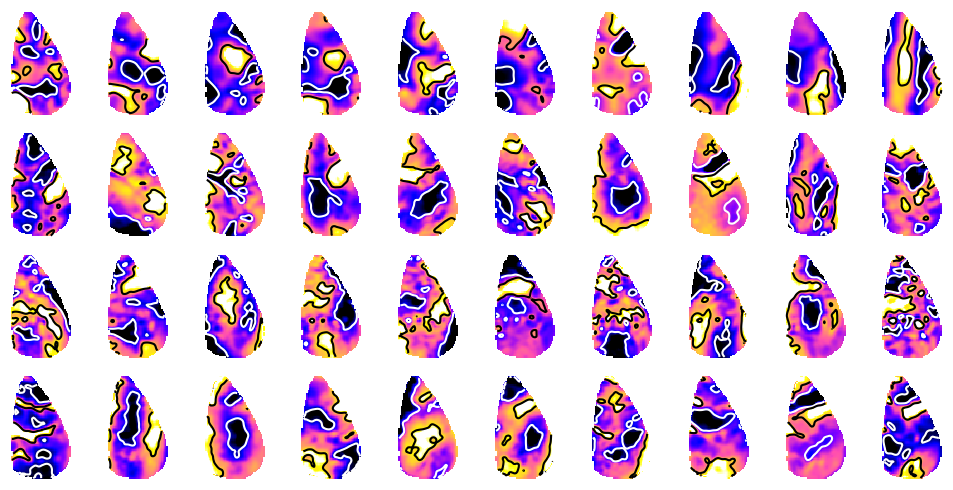

In [111]:
plt.figure(figsize=(10,5))
for i,f in enumerate(resized_components):
    ax = plt.subplot(4,10,i+1)
    #plt.title(f'shape: {f.shape}',fontsize=2)
    xmin = np.nanpercentile(f.ravel(),5)
    xmax = np.nanpercentile(f.ravel(),95)
    x1 = np.nanpercentile(f.ravel(),15)
    x2 = np.nanpercentile(f.ravel(),85)
        
    f[np.where(total_mask==0)] = np.nan
    ax.matshow(f,cmap=plt.cm.gnuplot2,vmin=xmin,vmax=xmax)
        
    ax.contour(f,[x1,x2],colors= ['w','k'])
    plt.axis('off')

plt.tight_layout()
    